# ML classifier - XGBoost

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [85]:
feature_list = ['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_90Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_Energy_training_firstorder_original_T1_contrast', 'original_firstorder_Entropy_training_firstorder_original_T1_contrast', 'original_firstorder_InterquartileRange_training_firstorder_original_T1_contrast', 'original_firstorder_Kurtosis_training_firstorder_original_T1_contrast', 'original_firstorder_Maximum_training_firstorder_original_T1_contrast', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_Mean_training_firstorder_original_T1_contrast', 'original_firstorder_Median_training_firstorder_original_T1_contrast', 'original_firstorder_Minimum_training_firstorder_original_T1_contrast', 'original_firstorder_Range_training_firstorder_original_T1_contrast', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_RootMeanSquared_training_firstorder_original_T1_contrast', 'original_firstorder_Skewness_training_firstorder_original_T1_contrast', 'original_firstorder_TotalEnergy_training_firstorder_original_T1_contrast', 'original_firstorder_Uniformity_training_firstorder_original_T1_contrast', 'original_firstorder_Variance_training_firstorder_original_T1_contrast', 'original_firstorder_10Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_90Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Energy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Entropy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_InterquartileRange_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Kurtosis_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Maximum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Mean_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Median_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Minimum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Range_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_RootMeanSquared_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Skewness_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_TotalEnergy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Uniformity_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Variance_training_firstorder_original_DTI_eddy_MD']
feature_list = [s.replace('original_firstorder_', '').split('_training_firstorder_')[0] for s in feature_list]
feature_list = list(dict.fromkeys(feature_list))
feature_list

['Sex',
 'Age at MRI',
 '10Percentile',
 '90Percentile',
 'Energy',
 'Entropy',
 'InterquartileRange',
 'Kurtosis',
 'Maximum',
 'MeanAbsoluteDeviation',
 'Mean',
 'Median',
 'Minimum',
 'Range',
 'RobustMeanAbsoluteDeviation',
 'RootMeanSquared',
 'Skewness',
 'TotalEnergy',
 'Uniformity',
 'Variance']

In [77]:
# CHOOSE THE FILTER
Filter = "Original" # ["Original", "SquareRoot", "Logarithm", "Exponential", "Wavelet", "Squared"]
    
# CHOOSE YOUR INPUT
#single_acquisitions = ["ADC", "DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast", "DTI_eddy_MD", "ASL", "T1", "T2"]
single_acquisitions = ["T1_contrast", "DTI_eddy_MD", "T2"]

# Save full evaluation 
save_eval = False

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set

    suffixes = [acquisition + ".csv" for acquisition in acquisitions]
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + Filter + "/training_firstorder_" + Filter.lower() + "_" + suffix) for suffix in suffixes]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + Filter + "/validation_firstorder_" + Filter.lower() + "_" + suffix) for suffix in suffixes]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{Filter}_XGBoost_evaluation.csv')
    elif environment == 'cluster':
        base_directory = "/cluster/project2/UCSF_PDGM_dataset/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + Filter + "/training_firstorder_" + Filter.lower() + "_" + suffix) for suffix in suffixes]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + Filter + "/validation_firstorder_" + Filter.lower() + "_" + suffix) for suffix in suffixes]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{Filter}_XGBoost_evaluation.csv')
    else:
        raise ValueError("Unknown environment: please set PYRADIOMICS_ENV to 'local' or 'cluster'")

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path, normalize=False):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_merged_data = train_merged_data.drop(106)    
    
    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        train_merged_data = normalize_data(train_merged_data, columns_to_exclude)

    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    #X_train = train_merged_data.drop(current_feature, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes 
    
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)

    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        validation_merged_data = normalize_data(validation_merged_data, columns_to_exclude)
    
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    
    y_validation = validation_target_columns
    
    
    return X_train, y_train, X_validation, y_validation

def normalize_data(df, columns_to_exclude):
    '''Andrew Ng suggests that gradient descent generally runs faster when features are rescaled, i.e. normalized and centred
    near 0. Although this is not necessarily relevant for XGBoost, which is a decision tree based method, 
    I add the normalization option here
    IMPORTANT: feature normalization decreased model performance with xgboost for Grade and IDH in this pipeline'''
    df_copy = df.copy()
    scaler = StandardScaler()
    for column in df_copy.columns:
        if column not in columns_to_exclude:
            df_copy[column] = scaler.fit_transform(df_copy[column].values.reshape(-1,1))
    return df_copy

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softmax",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3, # has to be the value of the case with the most categories (here: WHO grades (3))
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = MultiOutputClassifier(xgb_clf)
    
    clf.fit(X_train, y_train)
    return clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def save_evaluation(acquisition, target_columns, y_validation, y_pred, base_directory):
    # Save report of model performance to txt file
    output_directory = os.path.join(base_directory,"Model_performance")
    os.makedirs(output_directory, exist_ok=True)

    # Save report of model performance to txt file
    for i, col in enumerate(target_columns):
        report = classification_report(y_validation[col], y_pred[:, i])
        matrix = confusion_matrix(y_validation[col], y_pred[:, i])
        accuracy = balanced_accuracy_score(y_validation[col], y_pred[:, i])

        content = "Balanced accuracy for {col}: {accuracy}\n\n".format(col=col, accuracy=accuracy)
        content += "Classification Report for {col}:\n{report}\n".format(col=col, report=report)
        content += "Confusion Matrix for {col}:\n{matrix}\n".format(col=col, matrix=matrix)

        acq_name = ', '.join(item for item in acquisition) # convert acquisition tuple into str to join in name

        file_name = acq_name + "_{}_resultsFullEval.txt".format(col.replace('/', '_'))
        file_path = os.path.join(output_directory, file_name)
        with open(file_path, "w") as f:
            f.write(content)
            
def main():
    results = []
    num_combinations = 2 ** len(single_acquisitions) - 1
    
    with tqdm(total=num_combinations) as pbar:
        for r in range(1, len(single_acquisitions)+1):
            for acquisitions in combinations(single_acquisitions, r):
                # Get paths
                base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)

                # Load data
                X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

                # Train the model
                clf = train_model(X_train, y_train)

                # Make predictions on the validation set
                y_pred = make_predictions(clf, X_validation)

                # Assess model performance
                target_columns = ["WHO CNS Grade", "IDH"]
                result = {
                    "Acquisition": acquisitions,
                }
                
                for i, col in enumerate(target_columns):
                    report = classification_report(y_validation[col], y_pred[:, i], output_dict=True)

                    # Update the values to your results dictionary.
                    result.update({
                        col + " balanced-accuracy": balanced_accuracy_score(y_validation[col], y_pred[:, i]),
                        f"{col} f1-score": f1_score(y_validation[col], y_pred[:, i], average='micro')
                    })

                results.append(result)

                # Save detailed evaluation in text file
                if save_eval:
                    save_evaluation(acquisitions, target_columns, y_validation, y_pred, base_directory)
                pbar.update()


    results_df = pd.DataFrame(results)
    
    
    return results_df, eval_dir

results_df, eval_dir = main()

# Save results of model performance to csv
#results_df.to_csv(eval_dir, index=False)



  0%|                                                     | 0/7 [00:00<?, ?it/s]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_90Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_Energy_training_firstorder_original_T1_contrast', 'original_firstorder_Entropy_training_firstorder_original_T1_contrast', 'original_firstorder_InterquartileRange_training_firstorder_original_T1_contrast', 'original_firstorder_Kurtosis_training_firstorder_original_T1_contrast', 'original_firstorder_Maximum_training_firstorder_original_T1_contrast', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_Mean_training_firstorder_original_T1_contrast', 'original_firstorder_Median_training_firstorder_original_T1_contrast', 'original_firstorder_Minimum_training_firstorder_original_T1_contrast', 'original_firstorder_Range_training_firstorder_original_T1_contrast', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T1_cont

 14%|██████▍                                      | 1/7 [00:01<00:06,  1.01s/it]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_90Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Energy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Entropy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_InterquartileRange_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Kurtosis_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Maximum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Mean_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Median_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Minimum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Range_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_DTI_edd

 29%|████████████▊                                | 2/7 [00:02<00:05,  1.03s/it]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T2', 'original_firstorder_90Percentile_training_firstorder_original_T2', 'original_firstorder_Energy_training_firstorder_original_T2', 'original_firstorder_Entropy_training_firstorder_original_T2', 'original_firstorder_InterquartileRange_training_firstorder_original_T2', 'original_firstorder_Kurtosis_training_firstorder_original_T2', 'original_firstorder_Maximum_training_firstorder_original_T2', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T2', 'original_firstorder_Mean_training_firstorder_original_T2', 'original_firstorder_Median_training_firstorder_original_T2', 'original_firstorder_Minimum_training_firstorder_original_T2', 'original_firstorder_Range_training_firstorder_original_T2', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T2', 'original_firstorder_RootMeanSquared_training_firstorder_original_T2', 'original_firstorder_Skewness_training_

 43%|███████████████████▎                         | 3/7 [00:02<00:03,  1.02it/s]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_90Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_Energy_training_firstorder_original_T1_contrast', 'original_firstorder_Entropy_training_firstorder_original_T1_contrast', 'original_firstorder_InterquartileRange_training_firstorder_original_T1_contrast', 'original_firstorder_Kurtosis_training_firstorder_original_T1_contrast', 'original_firstorder_Maximum_training_firstorder_original_T1_contrast', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_Mean_training_firstorder_original_T1_contrast', 'original_firstorder_Median_training_firstorder_original_T1_contrast', 'original_firstorder_Minimum_training_firstorder_original_T1_contrast', 'original_firstorder_Range_training_firstorder_original_T1_contrast', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T1_cont

 57%|█████████████████████████▋                   | 4/7 [00:04<00:03,  1.03s/it]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_90Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_Energy_training_firstorder_original_T1_contrast', 'original_firstorder_Entropy_training_firstorder_original_T1_contrast', 'original_firstorder_InterquartileRange_training_firstorder_original_T1_contrast', 'original_firstorder_Kurtosis_training_firstorder_original_T1_contrast', 'original_firstorder_Maximum_training_firstorder_original_T1_contrast', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_Mean_training_firstorder_original_T1_contrast', 'original_firstorder_Median_training_firstorder_original_T1_contrast', 'original_firstorder_Minimum_training_firstorder_original_T1_contrast', 'original_firstorder_Range_training_firstorder_original_T1_contrast', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T1_cont

 71%|████████████████████████████████▏            | 5/7 [00:05<00:02,  1.05s/it]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_90Percentile_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Energy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Entropy_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_InterquartileRange_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Kurtosis_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Maximum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Mean_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Median_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Minimum_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_Range_training_firstorder_original_DTI_eddy_MD', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_DTI_edd

 86%|██████████████████████████████████████▌      | 6/7 [00:06<00:01,  1.26s/it]

['Sex', 'Age at MRI', 'original_firstorder_10Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_90Percentile_training_firstorder_original_T1_contrast', 'original_firstorder_Energy_training_firstorder_original_T1_contrast', 'original_firstorder_Entropy_training_firstorder_original_T1_contrast', 'original_firstorder_InterquartileRange_training_firstorder_original_T1_contrast', 'original_firstorder_Kurtosis_training_firstorder_original_T1_contrast', 'original_firstorder_Maximum_training_firstorder_original_T1_contrast', 'original_firstorder_MeanAbsoluteDeviation_training_firstorder_original_T1_contrast', 'original_firstorder_Mean_training_firstorder_original_T1_contrast', 'original_firstorder_Median_training_firstorder_original_T1_contrast', 'original_firstorder_Minimum_training_firstorder_original_T1_contrast', 'original_firstorder_Range_training_firstorder_original_T1_contrast', 'original_firstorder_RobustMeanAbsoluteDeviation_training_firstorder_original_T1_cont

 86%|██████████████████████████████████████▌      | 6/7 [00:07<00:01,  1.21s/it]


KeyboardInterrupt: 

## Show top results

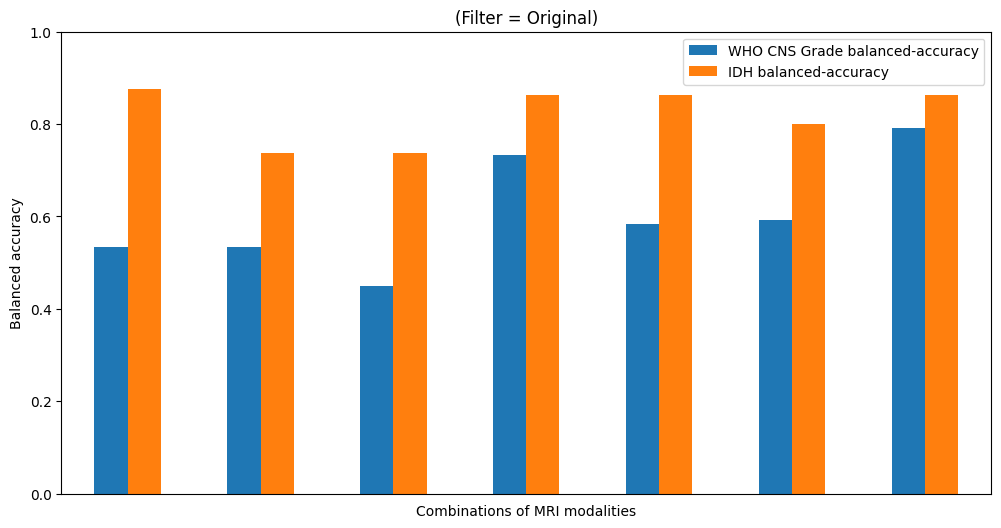

In [70]:
def visualize_comparison(results_df, Filter):
    # Select only columns with '_balanced-accuracy' in their names
    performance_columns = [col for col in results_df.columns if 'balanced-accuracy' in col]
    results_df = results_df[['Acquisition'] + performance_columns]

    # Plot the data
    ax = results_df.plot.bar(rot=0, figsize=(12, 6), x='Acquisition')
    plt.ylim(0, 1)
    plt.ylabel("Balanced accuracy")
    plt.xlabel("Combinations of MRI modalities")
    plt.title(f"(Filter = {Filter})")
    
    # Turn off the x-axis ticks and labels
    ax.axes.get_xaxis().set_ticks([])
    
    # Save the figure
    fig = ax.get_figure()
    fig.savefig(f"/Users/Gabriel/Desktop/bestOverall{Filter}.png", dpi=300)

# Import data 
#results_df = pd.read_csv('/Users/Gabriel/MSc_Dissertation/pyRadiomics/Model_performance/EvalAllModalities/Original_XGBoost_evaluation.csv')

# Call the function
visualize_comparison(results_df, Filter)


### Best modalities for WHO prediction

In [59]:
results_df = results_df[~results_df['Acquisition'].str.contains("'DWI'")] # Filter out all DWI combinations
filtered_df = results_df.nlargest(10, 'WHO CNS Grade balanced-accuracy')
pd.set_option('display.max_colwidth', None)
filtered_df


,Acquisition,WHO CNS Grade balanced-accuracy,WHO CNS Grade f1-score,IDH balanced-accuracy,IDH f1-score
167,"('T1_contrast', 'DTI_eddy_MD', 'T2')",0.791453,0.918367,0.862805,0.938776
45,"('T1_contrast', 'DTI_eddy_MD')",0.733333,0.918367,0.862805,0.938776
684,"('ADC', 'DTI_eddy_FA', 'SWI', 'T1_contrast', 'DTI_eddy_MD', 'T2')",0.733333,0.918367,0.862805,0.938776
53,"('ASL', 'T2')",0.724786,0.897959,0.788110,0.897959
627,"('SWI', 'T1_contrast', 'DTI_eddy_MD', 'ASL', 'T2')",0.724786,0.897959,0.812500,0.938776
109,"('DTI_eddy_FA', 'T1_contrast', 'DTI_eddy_MD')",0.716239,0.877551,0.862805,0.938776
149,"('SWI', 'DTI_eddy_MD', 'ASL')",0.716239,0.877551,0.800305,0.918367
153,"('SWI', 'ASL', 'T2')",0.716239,0.877551,0.800305,0.918367
7,"('ASL',)",0.666667,0.897959,0.788110,0.897959
12,"('ADC', 'SWI')",0.666667,0.897959,0.862805,0.938776


### Best modalities for IDH prediction

In [60]:
filtered_df = results_df.nlargest(10, 'IDH balanced-accuracy')
filtered_df

,Acquisition,WHO CNS Grade balanced-accuracy,WHO CNS Grade f1-score,IDH balanced-accuracy,IDH f1-score
100,"('DTI_eddy_FA', 'SWI', 'DTI_eddy_MD')",0.649573,0.857143,0.937500,0.979592
289,"('DTI_eddy_FA', 'SWI', 'DTI_eddy_MD', 'ASL')",0.649573,0.857143,0.937500,0.979592
36,"('SWI', 'DTI_eddy_MD')",0.600000,0.877551,0.925305,0.959184
285,"('DTI_eddy_FA', 'SWI', 'T1_contrast', 'DTI_eddy_MD')",0.591453,0.857143,0.925305,0.959184
288,"('DTI_eddy_FA', 'SWI', 'T1_contrast', 'T2')",0.516239,0.816327,0.925305,0.959184
556,"('DTI_eddy_FA', 'SWI', 'T1_contrast', 'DTI_eddy_MD', 'ASL')",0.582906,0.836735,0.925305,0.959184
99,"('DTI_eddy_FA', 'SWI', 'T1_contrast')",0.516239,0.816327,0.913110,0.938776
286,"('DTI_eddy_FA', 'SWI', 'T1_contrast', 'ASL')",0.516239,0.816327,0.913110,0.938776
287,"('DTI_eddy_FA', 'SWI', 'T1_contrast', 'T1')",0.582906,0.836735,0.913110,0.938776
101,"('DTI_eddy_FA', 'SWI', 'ASL')",0.658120,0.877551,0.900915,0.918367


### Best modalities for overall prediction

In [61]:
top = results_df.assign(sum=results_df['WHO CNS Grade balanced-accuracy'] + results_df['IDH balanced-accuracy']).nlargest(10, 'sum')
top

,Acquisition,WHO CNS Grade balanced-accuracy,WHO CNS Grade f1-score,IDH balanced-accuracy,IDH f1-score,sum
167,"('T1_contrast', 'DTI_eddy_MD', 'T2')",0.791453,0.918367,0.862805,0.938776,1.654258
45,"('T1_contrast', 'DTI_eddy_MD')",0.733333,0.918367,0.862805,0.938776,1.596138
684,"('ADC', 'DTI_eddy_FA', 'SWI', 'T1_contrast', 'DTI_eddy_MD', 'T2')",0.733333,0.918367,0.862805,0.938776,1.596138
100,"('DTI_eddy_FA', 'SWI', 'DTI_eddy_MD')",0.649573,0.857143,0.937500,0.979592,1.587073
289,"('DTI_eddy_FA', 'SWI', 'DTI_eddy_MD', 'ASL')",0.649573,0.857143,0.937500,0.979592,1.587073
109,"('DTI_eddy_FA', 'T1_contrast', 'DTI_eddy_MD')",0.716239,0.877551,0.862805,0.938776,1.579044
101,"('DTI_eddy_FA', 'SWI', 'ASL')",0.658120,0.877551,0.900915,0.918367,1.559034
145,"('SWI', 'T1_contrast', 'DTI_eddy_MD')",0.666667,0.897959,0.875000,0.959184,1.541667
184,"('ADC', 'DTI_eddy_FA', 'SWI', 'DTI_eddy_MD')",0.666667,0.897959,0.875000,0.959184,1.541667
360,"('SWI', 'T1_contrast', 'DTI_eddy_MD', 'ASL')",0.666667,0.897959,0.875000,0.959184,1.541667


### Which features are most critical?